# HW6, DATSCI W261
Team: Kuan Lin, Alejandro J. Rojas, Ricardo Barrera<br/>
Emails: kuanlin@ischool.berkeley.edu, ale@ischool.berkeley.edu, ricardofrank@ischool.berkeley.edu<br/>
Time of Initial Submission: 8:00 AM PST, Thursday, Feb 25, 2016<br/>
W261-1, Spring 2016 Week 6 Homework

# HW6.0. 
In mathematics, computer science, economics, or management science what is mathematical optimization?
 Give an example of a optimization problem that you have worked with directly or that your organization
 has worked on. Please describe the objective function and the decision variables. 
 Was the project successful (deployed in the real world)? Describe.

...to do

# HW6.1 
Optimization theory: 
For unconstrained univariate optimization what are the first order  Necessary Conditions for Optimality
 (FOC).  What are the second order optimality conditions (SOC)? Give a mathematical defintion. Also in 
 python, plot the univartiate function 
X^3 -12x^2-6 defined over the real  domain -6 to +6. 

Also plot its corresponding first and second derivative functions. Eyeballing these graphs, identify 
candidate optimal points and then classify them as local minimums or maximums. Highlight and label 
these points in your graphs. Justify your responses using the FOC and SOC.

For unconstrained multi-variate optimization what are the first order  Necessary Conditions for 
Optimality (FOC).  What are the second order optimality conditions (SOC)? Give a mathematical 
defintion. What is the Hessian matrix in this context?

...to do

# HW6.2
Taking x=1 as the first approximation(xt1) of a root of X^3 + 2x -4 = 0, use the Newton-Raphson 
method to calculate the second approximation (denoted as xt2) of this root. (Hint the solution is xt2=1.2)

f(x) = x<sup>3</sup> + 2x - 4<br/>
f'(x) = 3x + 2

Using Newton's Metnod:<br/>
x<sub>n+1</sub> = x<sub>n</sub> - f(x<sub>n</sub>)/f'(x<sub>n</sub>) = 1 - (1<sup>3</sup>+2\*1-4)/(3\*1+2) = 1 - (-0.2) = 1.2


# HW6.3 Convex optimization 
What makes an optimization problem convex? What are the first order  Necessary Conditions for 
Optimality in convex optimization.  What are the second order optimality conditions for convex 
optimization? Are both necessary to determine the maximum or minimum of candidate optimal solutions?

An optimization problem is convex if the cost function is continous and the second derivative is positive when evaluated for all points within the set of interest.  The first order necessary condition for optimality is still to have the first derivative to be zero.  The second order optimality is to have the second derivative greater than or equal to zero, which is automatically satisfied if the cost function is convex.  Therefore only the first order is necessary to determine the optimal solution in a convex problem.

Fill in the BLANKS here:<br/>
Convex minimization, a subfield of optimization, studies the problem of minimizing [<em>convex</em>] functions over [<em>convex</em>] sets. The [<em>convexity</em>] property can make optimization in some sense "easier" than the general case - for example, any local minimum must be a global minimum.

# HW 6.4
The learning objective function for weighted ordinary least squares (WOLS) (aka weight linear regression)
 is defined as follows:

0.5* sumOverTrainingExample i (weight_i * (W * X_i - y_i)^2)

Where training set consists of input variables X ( in vector form) and a target variable y, 
and W is the vector of coefficients for the linear regression model.

Derive the gradient for this weighted OLS by hand; showing each step and also explaining each step.

The original objective function is:
$$f(X) = 0.5 \cdot \sum w_{i}\cdot (W\cdot x_{i} - y_{i})^{2}$$

To find W that minimize the objective function, we take the derivative of f(x) with respect to W:
$$
\frac {\partial f}{\partial W} = 0.5 \cdot \sum w_{i}\cdot 2 \cdot (W \cdot x_{i} - y_{i}) \cdot \frac {\partial (W \cdot x_{i} - y_{i})}{\partial W}
= \sum w_{i} \cdot x_{i} \cdot (W \cdot x_{i} - y_{i})
$$

The above result is the gradient as defined by the weighte OLS

# HW 6.5
Write a MapReduce job in MRJob to do the training at scale of a weighted OLS model using gradient descent.

Generate one million datapoints just like in the following notebook: 
http://nbviewer.ipython.org/urls/dl.dropbox.com/s/kritdm3mo1daolj/MrJobLinearRegressionGD.ipynb

Weight each example as follows: 

weight(x)= abs(1/x)

Sample 1% of the data in MapReduce and use the sampled dataset to train a 
(weighted if available in SciKit-Learn) linear regression model locally using SciKit-Learn 
(http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Plot the resulting weighted linear regression model versus the original model that you used 
to generate the data. Comment on your findings.

In [1]:
import numpy as np
# generate 1 million samples
size = 1000000
x = np.random.uniform(-4, 4, size)
# True model: y = 1.0 * x - 4
y = x * 1.0 - 4 + np.random.normal(0,0.5,size)
data = zip(y,x)
np.savetxt('LinearRegression.csv',data,delimiter = ",")

In [4]:
%%writefile WLS_Gradient_Descend.py
from mrjob.job import MRJob

#Modified from class example to use weighted least square
#     
class MrJobBatchGDUpdate_LinearRegression(MRJob):
    # run before the mapper processes any input
    def read_weightsfile(self):
        # Read weights file
        with open('weights.txt', 'r') as f:
            self.weights = [float(v) for v in f.readline().split(',')]
        # Initialze gradient for this iteration
        self.partial_Gradient = [0]*len(self.weights)
        self.partial_count = 0.0
    
    # Calculate partial gradient for each example 
    def partial_gradient(self, _, line):
        D = (map(float,line.split(',')))
        # y_hat is the predicted value given current weights
        y_hat = self.weights[0]+self.weights[1]*D[1]
        # Update parial gradient vector with gradient form current example
        # weight each gradient by abs(1/x) as stated in the problem
        sample_weight = abs(1/D[1])
        # Cap sample weight so that we don't get some ridiculously large
        # weights when data is small
        if sample_weight > 10:
            sample_weight = 10.0
        elif sample_weight < 0.01:
            sample_weight = 0.01
        self.partial_Gradient =  [self.partial_Gradient[0] + sample_weight*(D[0]-y_hat), 
                                  self.partial_Gradient[1] + sample_weight*(D[0]-y_hat)*D[1]]
        # accumulate weights
        self.partial_count = self.partial_count + sample_weight
    
    # Finally emit in-memory partial gradient and partial count
    def partial_gradient_emit(self):
        yield None, (self.partial_Gradient,self.partial_count)
        
    # Accumulate partial gradient from mapper and emit total gradient 
    # Output: key = None, Value = gradient vector
    def gradient_accumulater(self, _, partial_Gradient_Record): 
        total_gradient = [0]*2
        total_count = 0.0
        for partial_Gradient,partial_count in partial_Gradient_Record:
            total_count = total_count + partial_count
            total_gradient[0] = total_gradient[0] + partial_Gradient[0]
            total_gradient[1] = total_gradient[1] + partial_Gradient[1]
        yield None, [v/total_count for v in total_gradient]
        # wieghted least square total gradient
        #yield None, [v for v in total_gradient]
    
    def steps(self):
        return [self.mr(mapper_init=self.read_weightsfile,
                       mapper=self.partial_gradient,
                       mapper_final=self.partial_gradient_emit,
                       reducer=self.gradient_accumulater)] 
    
if __name__ == '__main__':
    MrJobBatchGDUpdate_LinearRegression.run()

Overwriting WLS_Gradient_Descend.py


In [6]:
# Driver code

from numpy import random,array
from WLS_Gradient_Descend import MrJobBatchGDUpdate_LinearRegression

learning_rate = 0.05
stop_criteria = 0.000005

# Generate random values as inital weights
weights = array([random.uniform(-3,3),random.uniform(-3,3)])
# Write the weights to the files
with open('weights.txt', 'w+') as f:
    f.writelines(','.join(str(j) for j in weights))

# create a mrjob instance for batch gradient descent update over all data
mr_job = MrJobBatchGDUpdate_LinearRegression(args=['LinearRegression.csv', '--file', 'weights.txt'])
# Update centroids iteratively
i = 0
while(1):
    print "iteration ="+str(i)+"  weights =",weights
    # Save weights from previous iteration
    weights_old = weights
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            # value is the gradient value
            key,value =  mr_job.parse_output_line(line)
            # Update weights
            weights = weights + learning_rate*array(value)
    i = i + 1
    # Write the updated weights to file 
    with open('weights.txt', 'w+') as f:
        f.writelines(','.join(str(j) for j in weights))
    # Stop if weights get converged
    if(sum((weights_old-weights)**2)<stop_criteria):
        break
        
print "Final weights\n"
print weights

iteration =0  weights = [-2.31993502 -2.49050546]
iteration =1  weights =

 [-2.40331461 -1.55883276]
iteration =2  weights =

 [-2.48269569 -0.87591118]
iteration =3  weights =

 [-2.55823269 -0.3753223 ]
iteration =4  weights =

 [-2.63008444 -0.00838208]
iteration =5  weights =

 [-2.69841074  0.26059441]
iteration =6  weights =

 [-2.76336995  0.45776386]
iteration =7  weights =

 [-2.82511728  0.60229888]
iteration =8  weights =

 [-2.88380369  0.70825284]
iteration =9  weights =

 [-2.93957516  0.78592671]
iteration =10  weights =

 [-2.99257228  0.84287106]
iteration =11  weights =

 [-3.04292996  0.88462036]
iteration =12  weights =

 [-3.09077739  0.91523138]
iteration =13  weights =

 [-3.13623806  0.93767769]
iteration =14  weights =

 [-3.1794298   0.95413892]
iteration =15  weights =

 [-3.22046496  0.96621273]
iteration =16  weights =

 [-3.25945058  0.97507021]
iteration =17  weights =

 [-3.29648853  0.98156979]
iteration =18  weights =

 [-3.33167578  0.98634069]
iteration =19  weights =

 [-3.36510454  0.98984415]
iteration =20  weights =

 [-3.3968625   0.99241827]
iteration =21  weights =

 [-3.42703303  0.99431088]
iteration =22  weights =

 [-3.45569538  0.99570366]
iteration =23  weights =

 [-3.48292487  0.9967298 ]
iteration =24  weights =

 [-3.50879308  0.99748694]
iteration =25  weights =

 [-3.53336801  0.99804664]
iteration =26  weights =

 [-3.5567143  0.9984614]
iteration =27  weights =

 [-3.57889335  0.99876968]
iteration =28  weights =

 [-3.5999635  0.9989997]
iteration =29  weights =

 [-3.61998019  0.99917217]
iteration =30  weights =

 [-3.63899607  0.99930224]
iteration =31  weights =

 [-3.65706119  0.99940107]
iteration =32  weights =

 [-3.67422306  0.99947681]
iteration =33  weights =

 [-3.69052686  0.99953547]
iteration =34  weights =

 [-3.70601548  0.99958145]
iteration =35  weights =

 [-3.72072967  0.99961798]
iteration =36  weights =

 [-3.73470817  0.99964746]
iteration =37  weights =

 [-3.74798774  0.99967162]
iteration =38  weights =

 [-3.76060334  0.99969176]
iteration =39  weights =

 [-3.77258816  0.99970883]
iteration =40  weights =

 [-3.78397375  0.99972354]
iteration =41  weights =

 [-3.79479005  0.9997364 ]
iteration =42  weights =

 [-3.80506555  0.99974781]
iteration =43  weights =

 [-3.81482727  0.99975805]
iteration =44  weights =

 [-3.82410091  0.99976734]
iteration =45  weights =

 [-3.83291087  0.99977585]
iteration =46  weights =

 [-3.84128033  0.9997837 ]
iteration =47  weights =

 [-3.84923132  0.99979099]
iteration =48  weights =

 [-3.85678476  0.99979778]
iteration =49  weights =

 [-3.86396053  0.99980414]
iteration =50  weights =

 [-3.87077751  0.99981012]
iteration =51  weights =

 [-3.87725365  0.99981575]
iteration =52  weights =

 [-3.88340598  0.99982106]
iteration =53  weights =

 [-3.88925069  0.99982608]
iteration =54  weights =

 [-3.89480317  0.99983082]
iteration =55  weights =

 [-3.90007803  0.99983532]
iteration =56  weights =

 [-3.90508914  0.99983958]
iteration =57  weights =

 [-3.9098497   0.99984362]
iteration =58  weights =

 [-3.91437223  0.99984745]
iteration =59  weights =

 [-3.91866864  0.99985109]
iteration =60  weights =

 [-3.92275023  0.99985454]
iteration =61  weights =

 [-3.92662774  0.99985782]
iteration =62  weights =

 [-3.93031137  0.99986093]
iteration =63  weights =

 [-3.93381082  0.99986389]
iteration =64  weights =

 [-3.9371353   0.99986669]
iteration =65  weights =

 [-3.94029356  0.99986936]
iteration =66  weights =

 [-3.9432939   0.99987189]
iteration =67  weights =

 [-3.94614423  0.99987429]
iteration =68  weights =

 [-3.94885204  0.99987658]
iteration =69  weights =

 [-3.95142446  0.99987875]
iteration =70  weights =

 [-3.95386826  0.99988081]
iteration =71  weights =

 [-3.95618987  0.99988277]
Final weights

[-3.9583954   0.99988463]


Final Weights after 71 iterations:
[-3.9583954,   0.99988463]

In [7]:
# using sk-learn

# sample 1%
# since the data is randomly generated, grabbing the first 1% should do
sample_size = 1000000*0.01
sampled_count = 0
x = []
y = []
sample_weights = []
for line in open('LinearRegression.csv', 'r'):
    if sampled_count < sample_size:
        y_i, x_i = map(float, line.strip().split(','))
        x.append([x_i])
        y.append([y_i])
        sample_weights.append(abs(1/x_i))
        sampled_count += 1
    else:
        break
        
#print "%s, %s, %s"%(len(x), len(y), len(sample_weights))

# train the linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x, y, sample_weights)
# print out the coefficients:
print "slope:%s, intercept: %s"%(str(model.coef_), str(model.intercept_))

slope:[[ 1.00057978]], intercept: [-4.00085214]


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:25: DeprecationWarning: The n_jobs parameter in fit is deprecated and will be removed in 0.17. It has been moved from the fit method to the LinearRegression class constructor.


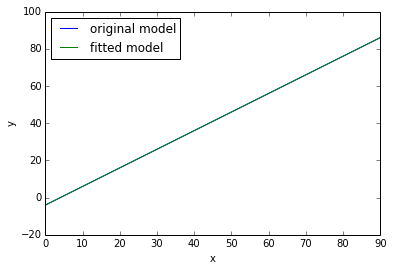

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# make plot for the original and the fitted models

x_vals = [x for x in range(0, 100, 10)]

plt.plot(x_vals, [x*1.0-4 for x in x_vals], label="original model")
plt.plot(x_vals, [x*0.99988463-3.9583954 for x in x_vals], label="fitted model")
plt.legend(loc="best")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

The two models are very close.

# HW6.6 Clean up notebook for GMM via EM

Using the following notebook as a starting point:

http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/0t7985e40fovlkw/EM-GMM-MapReduce%20Design%201.ipynb 

Improve this notebook as follows:
- Add in equations into the notebook (not images of equations) 
- Number the equations
- Make sure the equation notation matches the code and the code and comments refer to the equations numbers
- Comment the code
- Rename/Reorganize the code to make it more readable
- Rerun the examples similar graphics (or possibly better graphics)

...to do

# HW6.7  Implement Bernoulli Mixture Model via EM
Implement the EM clustering algorithm to determine Bernoulli Mixture Model for discrete data in MRJob.

As a unit test use the dataset in the following slides:

https://www.dropbox.com/s/maoj9jidxj1xf5l/MIDS-Live-Lecture-06-EM-Bernouilli-MM-Systems-Test.pdf?dl=0

Cross-check that you get the same cluster assignments and cluster Bernouilli models as presented in 
the slides after 25 iterations. Dont forget the smoothing.

As a full test: use the same dataset from HW 4.5, the Tweet Dataset. 
Using this data, you will implement a 1000-dimensional EM-based Bernoulli Mixture Model  algorithm in MrJob on the users
by their 1000-dimensional word stripes/vectors using K = 4.  Use the same smoothing as in the unit test.

Repeat this experiment using your KMeans MRJob implementation fron HW4.
Report the rand index score using the class code as ground truth label for both algorithms and comment on your findings.

In [16]:
# unit test data and converting unit test data into the same format as the full dataset

unit_test = ['hot chocolate cocoa beans',
             'cocoa ghana africa',
             'beans harvest ghana',
             'cocoa butter',
             'butter truffles',
             'sweet chocolate',
             'sweet sugar',
             'sugar cane brazil',
             'sweet sugar beet',
             'sweet cake icing',
             'cake black forest']

# convert to the format of USERID,CODE,TOTAL,WORD1_COUNT,WORD2_COUNT,...

# unique words
vocabs = set()
for doc in unit_test:
    for word in doc.split(' '): vocabs.add(word)
        
print str(vocabs)
        
writer = open('unit_test.txt', 'w')
for i, doc in enumerate(unit_test):
    words = doc.split(' ')
    # set all codes to 0, since we don't really have that data
    writer.write(str(i+1) + ',0,' + str(len(words)))
    for voc in vocabs:
        # counts for each unique words
        writer.write(',' + str(words.count(voc)))
    writer.write('\n')
writer.close()

set(['ghana', 'butter', 'cane', 'icing', 'truffles', 'sweet', 'brazil', 'africa', 'chocolate', 'cocoa', 'hot', 'beans', 'forest', 'cake', 'beet', 'sugar', 'harvest', 'black'])


In [5]:
%%writefile BEM_Initialization.py
import random

# initialize Bernoulli model for EM
# k: number of clusters
# data_file: file containing data in the specific format mentioned in the problem statement
def InitializeBEM(k, data_file):
    writer = open('cluster_assignments.txt', 'w')
    for line in open(data_file, 'r'):
        doc_id = line.strip().split(',')[0]
        # uniform random assignment for each cluster
        r_nk = [random.random() for i in range(k)]
        # normalize the assignment
        r_nk = map(lambda x: str(x/sum(r_nk)), r_nk)
        writer.write(doc_id + ',' + ','.join(r_nk) + '\n')
    writer.close()

Overwriting BEM_Initialization.py


In [1]:
%%writefile BEM_Iterate.py

# EM iteration implementation for the Bernoulli Mixture Model
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol
from mrjob.step import MRStep

class BEM(MRJob):
    
    #OUTPUT_PROTOCOL = RawValueProtocol
    # enable secondary sort
    SORT_VALUES = True
    
    def steps(self):
        return [
            MRStep(mapper_init=self.setK, mapper=self.max_mapper, 
                   reducer_init=self.load_soft_assignments, reducer=self.max_reducer),
            MRStep(reducer_init=self.load_apriori, reducer=self.exp_reducer)
        ]
    
    # set k (number of clusters) by looking at the first row of the initialization file
    def setK(self):
        for line in open('cluster_assignments.txt', 'r'):
            self.k = len(line.strip().split(',')[1:])
            break
    
    # loading up soft cluster assignments
    def load_soft_assignments(self):
        # soft cluster assignments
        self.soft_assignments = {}
        # a priori for each cluster
        self.a_k = None
        # total documents
        self.total_docs = 0
        for line in open('cluster_assignments.txt', 'r'):
            self.total_docs += 1
            lineArr = line.strip().split(',')
            # first element is the documentID, followed by soft assignments
            doc_id = lineArr[0]
            assignments = map(float, lineArr[1:])
            self.soft_assignments[doc_id] = assignments
            # assumulate a_k: cluster a priori
            if self.a_k == None: self.a_k = [0]*len(assignments)
            for i, assign in enumerate(assignments):
                self.a_k[i] += assign
        # normalize a_k (the a priori for each cluster)
        self.a_k = map(lambda x: x/self.total_docs, self.a_k)
    
    # mapper for the maximization step
    def max_mapper(self, _, line):
        lineArr = line.strip().split(',')
        docId = lineArr[0]
        known_clusterId = lineArr[1]
        for term_idx, word_count in enumerate(lineArr[3:]):
            # binarize word counts for bernoulli to work
            occurence = 0
            if int(word_count) > 0:
                occurence = 1
            for k in range(self.k):
                # emit the same data twice, first to calculate qmk, and second to pass along to calculate rnk
                # this way we don't need to store co-occurence vectors in memroy in reducer
                # secondary sort is required so that qmk is calculated first
                yield (term_idx, k), (0, docId, occurence)
                yield (term_idx, k), (1, docId, occurence)
    
    # reducer for the maximization step
    def max_reducer(self, term_cluster_id, term_occurences):
        termId, clusterId = term_cluster_id
        q_mk = [0.0]*len(self.a_k)
        q_normalized = False
        r_nk_sum = [0.0]*len(self.a_k)
        #print '--------' + str(term_cluster_id) + '------------'
        for term_occurence_data in term_occurences:
            flag, docId, occurence = term_occurence_data
            #print str(term_occurence_data)
            if flag == 0:
                # calculate q_mk
                for k in range(len(self.a_k)):
                    # soft assignment for this doc for this clusterID
                    r_nk = self.soft_assignments[docId][k] + 0.0001 # smoothing
                    r_nk_sum[k] += r_nk
                    q_mk[k] += r_nk*occurence
            else:
                if q_normalized == False:
                    # normalize term prob for each cluster
                    q_mk = [q/r for q,r in zip(q_mk, r_nk_sum)]
                    q_normalized = True
                # emit to next step to calculate the new r_nk
                for k, q in enumerate(q_mk):
                    if occurence == 0:
                        yield docId, (k, 1-q)
                    else:
                        yield docId, (k, q)
    
    # load up a priori for the expectation calculation.
    def load_apriori(self):
        # a priori for each cluster
        self.a_k = None
        # total documents
        self.total_docs = 0
        for line in open('cluster_assignments.txt', 'r'):
            self.total_docs += 1
            lineArr = line.strip().split(',')
            # first element is the documentID, followed by soft assignments
            doc_id = lineArr[0]
            assignments = map(float, lineArr[1:])
            # assumulate a_k: cluster a priori
            if self.a_k == None: self.a_k = [0]*len(assignments)
            for i, assign in enumerate(assignments):
                self.a_k[i] += assign
        # normalize a_k (the a priori for each cluster)
        self.a_k = map(lambda x: x/self.total_docs, self.a_k)
    
    # expectation step.  reducing from outputs of the maximazation reducer step
    def exp_reducer(self, docId, k_q):
        import numpy as np
        
        # sum of logs of q_mk to prevent underflow
        q_log_sums = {}
        
        # k is clusterID
        # q is either q_mk or (1-q_mk) depending on co-occurence
        for k_q_pair in k_q:
            k, q = k_q_pair
            if k not in q_log_sums:
                q_log_sums[k] = np.log(q)
            else:
                q_log_sums[k] += np.log(q)
                
        # convert to loglikelihood
        r_logliklihood = [np.log(self.a_k[k])+q_log_sums[k] for k in q_log_sums]
        
        # scale the loglikehood so that the exponentials don't zero out
        base_likelihood = max(r_logliklihood)
        #base_likelihood = 0.0
        r_liklihood = np.exp([val-base_likelihood for val in r_logliklihood])
        # normalizing constant
        norm_const = np.sum(r_liklihood)   
        
        yield docId, [r/norm_const for r in r_liklihood]
        
            
            
        
        

Overwriting BEM_Iterate.py


### Driver Program (Unit Test)

In [8]:
%reload_ext autoreload
%autoreload 2
from BEM_Initialization import InitializeBEM
from BEM_Iterate import BEM

# load the current cluster soft assigments
def load_soft_assignments():
    # soft cluster assignments
    soft_assignments = {}
    # a priori for each cluster
    a_k = None
    # total documents
    total_docs = 0
    for line in open('cluster_assignments.txt', 'r'):
        total_docs += 1
        lineArr = line.strip().split(',')
        # first element is the documentID, followed by soft assignments
        doc_id = lineArr[0]
        assignments = map(float, lineArr[1:])
        soft_assignments[doc_id] = assignments
        # assumulate a_k: cluster a priori
        if a_k == None: a_k = [0]*len(assignments)
        for i, assign in enumerate(assignments):
            a_k[i] += assign
    # normalize a_k (the a priori for each cluster)
    a_k = map(lambda x: x/total_docs, a_k)
    return (a_k, soft_assignments)

# initialize soft assignment
InitializeBEM(2, 'unit_test.txt') # unit test
a_k, soft_assignments = load_soft_assignments()

# stop criterions
max_iter = 25
min_change = 0.0005 # minimal change required to continue

mrJob = BEM(args=['unit_test.txt', '--file', 'cluster_assignments.txt'])
iter_num = 0
while(1):
    with mrJob.make_runner() as runner:
        runner.run()
        iter_num += 1
        iter_max_change = 0
        print "-----iter: " + str(iter_num) + "------"
        writer = open('cluster_assignments.txt', 'w')
        for line in runner.stream_output():
            docId,cluster_assignments =  mrJob.parse_output_line(line)
            # max change in soft cluster assignment for this document
            doc_max_change = max(abs(i-j) for i,j in zip(soft_assignments[docId], cluster_assignments))
            if doc_max_change > iter_max_change:
                iter_max_change = doc_max_change
            print docId, cluster_assignments
            writer.write(docId + ',' + ','.join(map(str, cluster_assignments)) + '\n')
        writer.close()
        a_k, soft_assignments = load_soft_assignments()
        #if iter_num >= max_iter or iter_max_change < min_change:
        if iter_num >= max_iter:
            break

print
print "final mixture cluster prior:"
print a_k

-----iter: 1------
1 [0.9841585507906842, 0.01584144920931574]
10 [0.32199980606917855, 0.6780001939308214]
11 [0.003534001654162192, 0.9964659983458377]
2 [0.6432407700372131, 0.3567592299627869]
3 [0.7817890409170634, 0.21821095908293672]
4 [0.49876109826856335, 0.5012389017314368]
5 [0.9604162574349364, 0.03958374256506358]
6 [0.9099513065739586, 0.09004869342604137]
7 [0.6360756469375456, 0.3639243530624544]
8 [0.36233334685072227, 0.6376666531492776]
9 [0.5700100301635934, 0.4299899698364066]
-----iter: 2------


1 [0.9999999929552807, 7.044719253653194e-09]
10 [0.0009858693707719434, 0.9990141306292281]
11 [1.4029390197253822e-13, 0.9999999999998598]
2 [0.9668130535220145, 0.03318694647798543]
3 [0.9993313199476418, 0.0006686800523582232]
4 [0.9619145041002902, 0.03808549589970989]
5 [0.9995905844919831, 0.0004094155080169316]
6 [0.9979966458923301, 0.0020033541076699387]
7 [0.43618937501535965, 0.5638106249846404]
8 [0.00900107404524053, 0.9909989259547595]
9 [0.356792929636158, 0.6432070703638421]
-----iter: 3------


1 [1.0, 6.859943928435365e-25]
10 [5.721184969175686e-15, 0.9999999999999942]
11 [9.935983094277617e-25, 1.0]
2 [0.999999999908386, 9.161395664527223e-11]
3 [1.0, 2.1085374147025678e-17]
4 [0.9999999455162559, 5.4483744073972285e-08]
5 [0.9999999999479221, 5.207791671142214e-11]
6 [0.99999707062553, 2.9293744699545234e-06]
7 [0.00824218520382434, 0.9917578147961756]
8 [2.917405340315555e-11, 0.999999999970826]
9 [0.0008288361290396704, 0.9991711638709604]
-----iter: 4------


1 [1.0, 5.213676899031947e-34]
10 [5.9963519071645615e-19, 1.0]
11 [1.4509397619105832e-25, 1.0]
2 [1.0, 7.849427757674461e-26]
3 [1.0, 1.3926714537732041e-25]
4 [1.0, 7.798491155616246e-18]
5 [1.0, 2.159785069558342e-17]
6 [0.9999998789446489, 1.2105535110612468e-07]
7 [5.98671462943131e-08, 0.9999999401328538]
8 [6.389575259374715e-23, 1.0]
9 [2.2835350133943594e-14, 0.9999999999999772]
-----iter: 5------


1 [1.0, 4.945512715004127e-34]
10 [5.9003510944300595e-19, 1.0]
11 [1.473633711634636e-25, 1.0]
2 [1.0, 7.71886545816135e-26]
3 [1.0, 1.3720735666990666e-25]
4 [1.0, 7.720409686286107e-18]
5 [1.0, 2.14410092176254e-17]
6 [0.9999998793391444, 1.2066085575677696e-07]
7 [5.90428074040732e-11, 0.9999999999409571]
8 [6.553626846736712e-26, 1.0]
9 [2.624037374416219e-19, 1.0]
-----iter: 6------


1 [1.0, 4.9454924388529505e-34]
10 [5.900350441306297e-19, 1.0]
11 [1.4736338548612712e-25, 1.0]
2 [1.0, 7.71886466206849e-26]
3 [1.0, 1.3720734387709783e-25]
4 [1.0, 7.720409256919781e-18]
5 [1.0, 2.1441008364797553e-17]
6 [0.9999998793396, 1.2066039999880676e-07]
7 [5.901925750467609e-11, 0.9999999999409808]
8 [6.551014543810337e-26, 1.0]
9 [2.6229908757229067e-19, 1.0]
-----iter: 7------


1 [1.0, 4.945492416327612e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.206603994487064e-07]
7 [5.90192574955537e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 8------


1 [1.0, 4.945492416300413e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.206603994480428e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 9------


1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 10------


1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 11------


1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 12------


1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 13------


1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 14------


1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 15------


1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 16------


1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 17------


1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 18------


1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 19------


1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 20------


1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 21------


1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 22------


1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 23------


1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 24------


1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]
-----iter: 25------
1 [1.0, 4.945492416300342e-34]
10 [5.900350441318267e-19, 1.0]
11 [1.4736338548601244e-25, 1.0]
2 [1.0, 7.718864662077045e-26]
3 [1.0, 1.3720734387722992e-25]
4 [1.0, 7.720409256923786e-18]
5 [1.0, 2.144100836480327e-17]
6 [0.9999998793396006, 1.2066039944804198e-07]
7 [5.901925749555391e-11, 0.9999999999409808]
8 [6.551014542775672e-26, 1.0]
9 [2.6229908753160136e-19, 1.0]

final mixture cluster prior:
[0.5454545344908199, 0.4545454655092181]


The unit test result is very similar to the examples in the book in terms of both the calculated cluster prior probs and the soft assignments.

### Driver Code (Bernoulli EM full test)

In [ ]:
%reload_ext autoreload
%autoreload 2
from BEM_Initialization import InitializeBEM
from BEM_Iterate import BEM

# load the current cluster soft assigments
def load_soft_assignments():
    # soft cluster assignments
    soft_assignments = {}
    # a priori for each cluster
    a_k = None
    # total documents
    total_docs = 0
    for line in open('cluster_assignments.txt', 'r'):
        total_docs += 1
        lineArr = line.strip().split(',')
        # first element is the documentID, followed by soft assignments
        doc_id = lineArr[0]
        assignments = map(float, lineArr[1:])
        soft_assignments[doc_id] = assignments
        # assumulate a_k: cluster a priori
        if a_k == None: a_k = [0]*len(assignments)
        for i, assign in enumerate(assignments):
            a_k[i] += assign
    # normalize a_k (the a priori for each cluster)
    a_k = map(lambda x: x/total_docs, a_k)
    return (a_k, soft_assignments)

# initialize soft assignment
InitializeBEM(4, 'topUsers_Apr-Jul_2014_1000-words.txt') # four clusters on full dataset
a_k, soft_assignments = load_soft_assignments()

# stop criterions
max_iter = 100
min_change = 0.0005 # minimal change required to continue

mrJob = BEM(args=['topUsers_Apr-Jul_2014_1000-words.txt', '--file', 'cluster_assignments.txt'])
iter_num = 0
while(1):
    with mrJob.make_runner() as runner:
        runner.run()
        iter_num += 1
        iter_max_change = 0
        writer = open('cluster_assignments.txt', 'w')
        for line in runner.stream_output():
            docId,cluster_assignments =  mrJob.parse_output_line(line)
            # max change in soft cluster assignment for this document
            doc_max_change = max(abs(i-j) for i,j in zip(soft_assignments[docId], cluster_assignments))
            if doc_max_change > iter_max_change:
                iter_max_change = doc_max_change
            writer.write(docId + ',' + ','.join(map(str, cluster_assignments)) + '\n')
        writer.close()
        a_k, soft_assignments = load_soft_assignments()
        if iter_num >= max_iter:
            print "max iter number reached"
            break
        if iter_max_change < min_change:
            print "min change threshold reached"
            break

print
print "final mixture cluster prior:"
print a_k

### K-Mean Implementation
Same setup as HW4.5

In [1]:
%%writefile Kmeans.py
from numpy import argmin, array, random
from mrjob.job import MRJob
from mrjob.step import MRJobStep
from itertools import chain

#Calculate find the nearest centroid for data point 
def MinDist(datapoint, centroid_points):
    datapoint = array(datapoint)
    centroid_points = array(centroid_points)
    diff = datapoint - centroid_points 
    diffsq = diff*diff
    # Get the nearest centroid for each instance
    minidx = argmin(list(diffsq.sum(axis = 1)))
    return minidx

#Check whether centroids converge
def stop_criterion(centroid_points_old, centroid_points_new,T):
    oldvalue = list(chain(*centroid_points_old))
    newvalue = list(chain(*centroid_points_new))
    Diff = [abs(x-y) for x, y in zip(oldvalue, newvalue)]
    Flag = True
    for i in Diff:
        if(i>T):
            Flag = False
            break
    return Flag

class MRKmeans(MRJob):
    centroid_points=[]
    k=4
    dim=1000
    def steps(self):
        return [
            MRJobStep(mapper_init = self.mapper_init, mapper=self.mapper,combiner = self.combiner,reducer=self.reducer)
               ]
    #load centroids info from file
    def mapper_init(self):
        self.centroid_points = [map(float,s.split('\n')[0].split(',')) for s in open("Centroids.txt").readlines()]
        self.k = len(self.centroid_points)
        self.k = len(self.centroid_points[0])
        open('/data/w261/hw4/fitted_results.txt', 'w').close()
    #load data and output the nearest centroid index and data point 
    def mapper(self, _, line):
        lineArr = line.strip().split(',')
        user_id = lineArr[0]
        user_class = lineArr[1]
        user_total_words = float(lineArr[2])
        # normalize by user total word counts
        D = (map(lambda x: float(x)/user_total_words,lineArr[3:]))
        fitted_centroid_idx = int(MinDist(D,self.centroid_points))
        with open('/data/w261/hw4/fitted_results.txt', 'a') as f:
            f.writelines(','.join([str(fitted_centroid_idx), user_class, user_id]) + '\n')
        yield fitted_centroid_idx, ([1]+D)
    #Combine sum of data points locally
    def combiner(self, idx, inputdata):
        datasum = []
        for data in inputdata:
            if len(datasum) == 0:
                datasum = array(data)
            else:
                datasum = datasum + data
        yield idx, list(datasum)    
    #Aggregate sum for each cluster and then calculate the new centroids
    def reducer(self, idx, inputdata): 
        #print "running reducer for centroid index %s"%idx
        centroids = []
        num = [0]*self.k 
        for i in range(self.k):
            centroids.append([0]*self.dim)
        for data in inputdata:
            n = data[0]
            data = data[1:]
            num[idx] = num[idx] + n
            for data_idx, data_val in enumerate(data):
                centroids[idx][data_idx] = centroids[idx][data_idx] + data_val
        for centroid_val_idx, centroid_val in enumerate(centroids[idx]):
            centroids[idx][centroid_val_idx] = centroid_val/num[idx]
        #with open('/data/w261/hw4/Centroids.txt', 'a') as f:
        #    f.writelines(','.join(map(str,centroids[idx])) + '\n')
        yield idx,centroids[idx]
      
if __name__ == '__main__':
    MRKmeans.run()

Writing Kmeans.py


In [ ]:
%%writefile kmeans_driver.py
from numpy import random
from random import randint
from Kmeans import MRKmeans, stop_criterion
import sys

init_options = sys.argv[1].upper()

mr_job = MRKmeans(args=['topUsers_Apr-Jul_2014_1000-words.txt', '--file',  'Centroids.txt'])

# function that prints out purity results of the fitted clusters
def printFittedResults():
    results = {}
    for line in open('fitted_results.txt', 'r'):
        line = line.strip()
        if line == '': continue
        lineArr = line.split(',')
        fitted_class = lineArr[0]
        actual_class = lineArr[1]
        if fitted_class not in results:
            results[fitted_class] = {actual_class: 1, 'total': 1}
        else:
            fitted_results = results[fitted_class]
            fitted_results['total'] += 1
            if actual_class not in fitted_results:
                fitted_results[actual_class] = 1
            else:
                fitted_results[actual_class] += 1
    for fitted_class in results:
        fitted_results = results[fitted_class]
        print '---------------------------------'
        print "Fitted Cluster Index: %s" % fitted_class
        print "\ttotal records: %s" % fitted_results['total']
        for actual_class in fitted_results:
            if actual_class != 'total':
                print "\tactual class %s: %s [%.4f]" % (actual_class, fitted_results[actual_class], float(fitted_results[actual_class])/fitted_results['total'])

#Geneate k initial centroids with uniform distribution
def generateKUniform(k, feature_size, lower_bound, upper_bound):
    results = []
    for i in range(k):
        results.append([random.uniform(0,0.5) for i in range(feature_size)])
    return results

# randomly perturb from user-wide aggregated data
def randomPerturbUserWide(k):
    summary_data = []
    results = []
    #summary_total_count = 0
    for line in open('topUsers_Apr-Jul_2014_1000-words_summaries.txt', 'r'):
        line = line.strip()
        if line.startswith('ALL_CODES,'):
            lineArr = line.split(',')
            #summary_total_count = float(lineArr[2])
            summary_data = map(float, lineArr[3:])
            break
    for i in range(k):
        perturbed_data = map(lambda x: x+random.uniform(0,10), summary_data)
        perturbed_sum = sum(perturbed_data)
        results.append(map(lambda x: x/perturbed_sum, perturbed_data))
    return results

# randomly pick k records from data as centroids
def randomPickKUsers(k):
    results = []
    data = []
    for line in open('topUsers_Apr-Jul_2014_1000-words.txt', 'r'):
        line = line.strip()
        if line == '': continue
        data.append(line)
    for i in range(k):
        selectedIdx = randint(0, len(data)-1)
        selectedLine = data[selectedIdx].split(',')
        total_words = float(selectedLine[2])
        results.append(map(lambda x: float(x)/total_words, selectedLine[3:]))
    return results

# find averages from class-wide distribution as the initilizing points
def loadTrainedCentroids():
    results = []
    for line in open('topUsers_Apr-Jul_2014_1000-words_summaries.txt', 'r'):
        line = line.strip()
        if line == '' or not line.startswith('CODE,'): continue
        lineArr = line.split(',')
        total_words = float(lineArr[2])
        results.append(map(lambda x: float(x)/total_words, lineArr[3:]))
    return results

# persist centroid points to disc
def saveCentroid():
    with open('Centroids.txt', 'w+') as f:
        f.writelines(','.join(str(j) for j in i) + '\n' for i in centroid_points)

# feature_size
dim = 1000
# convergence threahold
thold = 0.001

if init_options == 'A':
    # (A) K=4, uniform random centroids
    print "K=4, uniformly random initialization"
    centroid_points = randomPickKUsers(4)
elif init_options == 'B':
    # (B) K=2 with perturbation-centroid
    print "K=2, perturbed centroids from user-wide aggregation"
    centroid_points = randomPerturbUserWide(2)
elif init_options == 'C':
    # (C) K=4 with perturbation-centroid
    print "K=4, perturbed centroids from user-wide aggregation"
    centroid_points = randomPerturbUserWide(4)
else:
    # (D) K=4 with trained centroid
    print "Initialize centroids with training data"
    centroid_points = loadTrainedCentroids()

# save centroid initialization
saveCentroid()

# Update centroids iteratively
i = 0
while(1):
    # save previous centoids to check convergency
    centroid_points_old = centroid_points[:]
    #print "iteration"+str(i)+":"
    with mr_job.make_runner() as runner:
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            #print key, value
            centroid_points[key] = value
    # persist the current centroid point
    saveCentroid()
    i = i + 1
    if(stop_criterion(centroid_points_old,centroid_points,thold)):
        break
#print "Centroids\n"
#print centroid_points
print "converged at iteration: %s" % i
printFittedResults()

(Since it's the same code from HW4.5, I am not going to re-run it.  I will use the fitted results from last time for the analysis below)

In [6]:
# custom implementation for (unadjusted) Rand Index

def RandIndexUnadjusted(true_labels, pred_labels):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    # pair-wise decision to calculate rand index
    for i, true_label1 in enumerate(true_labels):
        pred_label1 = pred_labels[i]
        
        for j, true_label2 in enumerate(true_labels[i+1:]):
            pred_label2 = pred_labels[i+1:][j]
            
            if (pred_label1 == pred_label2) and (true_label1 == true_label2): # true positive
                tp += 1
            elif (pred_label1 != pred_label2) and (true_label1 != true_label2): # true negative
                tn += 1
            elif (pred_label1 == pred_label2) and (true_label1 != true_label2): # false positive
                fp += 1
            elif (pred_label1 != pred_label2) and (true_label1 == true_label2): # false negative
                fn += 1
    
    return float(tp+tn)/(tp+fp+fn+tn)
            
    

In [7]:
# calculate rand index

def showRandIndex():
    from sklearn.metrics import adjusted_rand_score

    label_data_file = 'topUsers_Apr-Jul_2014_1000-words.txt'
    em_result_file = 'cluster_assignments.txt' # results from EM
    k_mean_result_file = 'fitted_results.txt' # results from kmean

    label_data = {}
    test_data = {}
    
    # results from EM
    for line in open(label_data_file, 'r'):
        lineArr = line.strip().split(',')
        label_data[lineArr[0]] = int(lineArr[1]) # get true label

    for line in open(em_result_file, 'r'):
        lineArr = line.strip().split(',')
        assignments = map(float, lineArr[1:])
        test_data[lineArr[0]] = assignments.index(max(assignments)) # get em label (largest prob)

    label = []
    pred = []

    for key in label_data:
        label.append(label_data[key])
        pred.append(test_data[key])

    print "Rand Idex for EM (custom implementation): %s"%RandIndexUnadjusted(label, pred)
    print "Ajust Rand Idex for EM (sciki-learn): %s"%adjusted_rand_score(label, pred)
    
    # results from kmean
    label = []
    pred = []
    # the fitted result file from kmean has the first index as the predicted label
    # and the second index as the true label
    for line in open(k_mean_result_file, 'r'):
        lineArr = line.strip().split(',')
        label.append(int(lineArr[1]))
        pred.append(int(lineArr[0]))
    
    print "Rand Idex for KMean (custom implementation): %s"%RandIndexUnadjusted(label, pred)
    print "Ajust Rand Idex for KMean (sciki-learn): %s"%adjusted_rand_score(label, pred)

showRandIndex()

Rand Idex for EM (custom implementation): 0.794714714715
Ajust Rand Idex for EM (sciki-learn): 0.594783912384
Rand Idex for KMean (custom implementation): 0.633263263263
Ajust Rand Idex for KMean (sciki-learn): 0.292210024622
